In [1]:
%pylab inline

import os
import itertools as it
from astropy.io import fits
from astropy.stats import signal_to_noise_oir_ccd as SNR_astropy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import ColorConverter

cc = ColorConverter()

from tools.stats import err, binner

from styles.slides import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_residual_hist(residuals, labels, keywords, res_lbs, limits=((-0.7, 0.7), (1.3, 3.0)), colors=((samples["light"], samples["dark"]), "#218380"), nbins=15):
    residual_a, residual_b = residuals
    color_a, color_b = colors
    label_a, label_b = labels
    xlm, ylm = limits

    fig, axs = subplots(1, len(keywords), figsize=(10, 5), sharex=True, sharey=True)

    axr = []
    for ax in axs:
        divider = make_axes_locatable(ax)
        axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))

        plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
        axr[-1].set_ylim(0, 1.2)

    axs = row_stack((axr, axs))

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.4, 0, 0.4])
    axs[0, 0].set_ylabel(r"\bf $N/N_\text{max}$")
    axs[1, 0].set_ylabel(r"\bf $u-r$")

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        if i==0:
            med_a = median(residual_a[keywords[j]])
            p16_a, p84_a = percentile(residual_a[keywords[j]], [16.0, 84.0])

            med_b = median(residual_b[keywords[j]])
            p16_b, p84_b = percentile(residual_b[keywords[j]], [16.0, 84.0])

            N_a = histogram(residual_a[keywords[j]], 20, range=xlm)[0].max().repeat(residual_a[keywords[j]].size)
            N_b = histogram(residual_b[keywords[j]], 20, range=xlm)[0].max().repeat(residual_b[keywords[j]].size)

            axs[i, j].hist(residual_b[keywords[j]], 20, range=xlm, weights=1.0/N_b, histtype="stepfilled", color=color_b, lw=0, label=label_b, alpha=0.5)
            axs[i, j].hist(residual_a[keywords[j]], 20, range=xlm, weights=1.0/N_a, histtype="stepfilled", color=color_a[1], lw=0, label=label_a)

            med_a_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_a, 0.0)))+array([0,0.2])
            med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
            axs[i, j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_a[0],"ec":"none"})
            axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})
        else:
            xa, ya, ea = binner(lcolor, residual_a[keywords[j]], nbins, ylm, "median")
            xb, yb, eb = binner(lcolor, residual_b[keywords[j]], nbins, ylm, "median")

            axs[i, j].plot(gaussian_filter(yb,1.5), xb, "-", color=color_b, lw=2)
            axs[i, j].fill_betweenx(xb, gaussian_filter(yb-eb[0],1.5), gaussian_filter(yb+eb[1],1.5), facecolor=color_b, lw=0, alpha=0.5)

            axs[i, j].plot(gaussian_filter(ya,1.5), xa, "-", color=color_a[0], lw=1.5)
            axs[i, j].fill_betweenx(xa, gaussian_filter(ya-ea[0],1.5), gaussian_filter(ya+ea[1],1.5), facecolor=color_a[1], lw=0)

            axs[i, j].axvline(ls=":", color="k", lw=0.7)
            axs[i, j].axhline(2.22, ls=":", color="k", lw=0.7)

            axs[i, j].set_xlabel(res_lbs[keywords[j]])

    axs[1, 0].set_ylim(xa[0], xa[-1])
    axs[0, 0].legend(loc=1)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)
    
    return None

In [3]:
def N_pix_spec(R=1800., D=3., ps=0.396):
    return 2*R*D/ps

def N_pix_imag(D=3., ps=0.396):
    return pi*(D/(2*ps))**2

def F(SNR, F_sky, N_pix, t=900., readout_noise=4., dark_noise=0., Gain=1.):
    return (SNR**2*t*Gain + sqrt(SNR**4*t*Gain**2 + 4*t**2*Gain**2*SNR**2*N_pix*(t*F_sky*Gain + t*dark_noise + readout_noise**2)))/(2*t**2*Gain**2)

def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas):
    return (model_jpas-model_spec) - (median(residual_jpas)-median(residual_spec))

In [4]:
#download and load spectroscopic throughput from SDSS
#load tables
snr = genfromtxt("data/sample-obs/snr_spec.txt", dtype=None, names=True)
cat = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)

_in_snr = array([i for i in xrange(cat.size) if cat["input_file"][i] in snr["input_file"]], dtype=np.int)

cat = cat[_in_snr]

snr[cat["u_mag"]>0]
cat[cat["u_mag"]>0]

#load outputs from S/N tests
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

#original TTA
sdss_tta = genfromtxt("../inputs/tta_cb13/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#low-S/N test (S/N=20 for all spectral resolutions)
sdss_lsn = genfromtxt("../inputs/proof_sn/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_lsn = genfromtxt("../inputs/proof_sn/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_lsn = genfromtxt("../inputs/proof_sn/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#high-S/N test (S/N=999.9 for all spectral resolutions)
sdss_hsn = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
jpas_hsn = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
spec_hsn = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

sdss_lsn["M_mod"] = log10(sdss_lsn["M_mod"])
jpas_lsn["M_mod"] = log10(jpas_lsn["M_mod"])
spec_lsn["M_mod"] = log10(spec_lsn["M_mod"])

sdss_hsn["M_mod"] = log10(sdss_hsn["M_mod"])
jpas_hsn["M_mod"] = log10(jpas_hsn["M_mod"])
spec_hsn["M_mod"] = log10(spec_hsn["M_mod"])

#compute residuals and discrepancies
sdss_res_tta = dict(
    M=err(ssag_tta["M_lib"], sdss_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_tta["Av_mod"], False)
)
jpas_res_tta = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res_tta = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict([(k, unbiased_disc(spec_tta[k+"_mod"], jpas_tta[k+"_mod"], spec_res_tta[k], jpas_res_tta[k])) for k in kws])

sdss_res_lsn = dict(
    M=err(ssag_tta["M_lib"], sdss_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_lsn["Av_mod"], False)
)
jpas_res_lsn = dict(
    M=err(ssag_tta["M_lib"], jpas_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_lsn["Av_mod"], False)
)
spec_res_lsn = dict(
    M=err(ssag_tta["M_lib"], spec_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_lsn["Av_mod"], False)
)
lsn_con = dict([(k, unbiased_disc(spec_lsn[k+"_mod"], jpas_lsn[k+"_mod"], spec_res_lsn[k], jpas_res_lsn[k])) for k in kws])

sdss_res_hsn = dict(
    M=err(ssag_tta["M_lib"], sdss_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_hsn["Av_mod"], False)
)
jpas_res_hsn = dict(
    M=err(ssag_tta["M_lib"], jpas_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_hsn["Av_mod"], False)
)
spec_res_hsn = dict(
    M=err(ssag_tta["M_lib"], spec_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_hsn["Av_mod"], False)
)
hsn_con = dict([(k, unbiased_disc(spec_hsn[k+"_mod"], jpas_hsn[k+"_mod"], spec_res_hsn[k], jpas_res_hsn[k])) for k in kws])

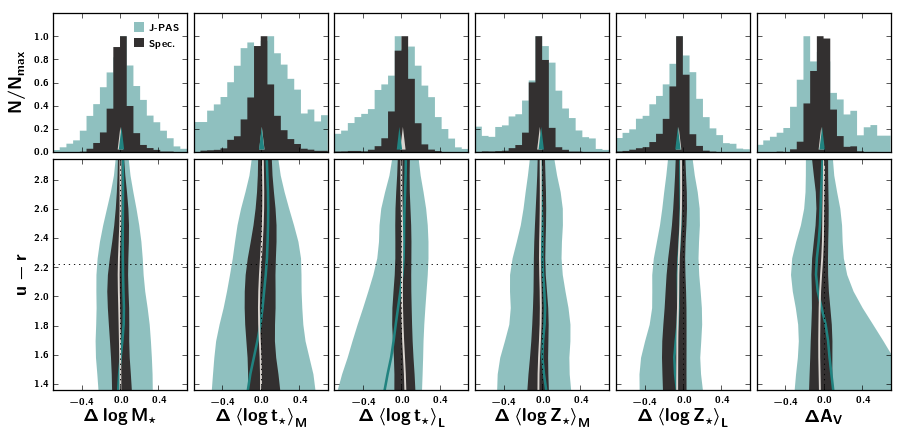

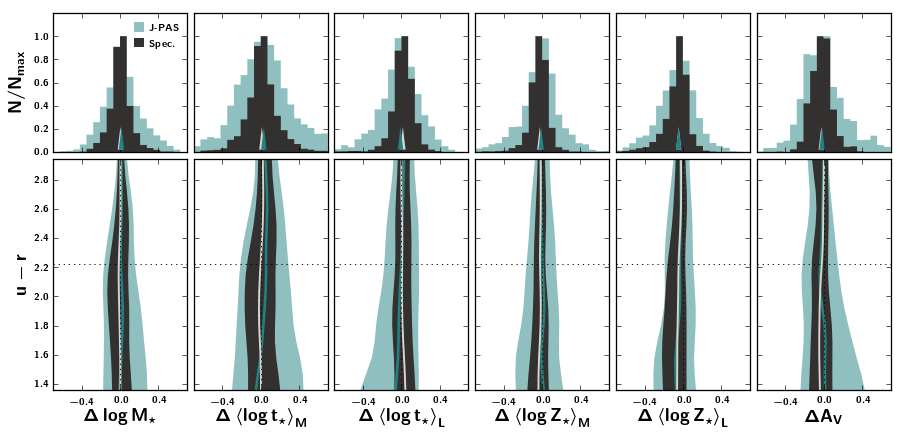

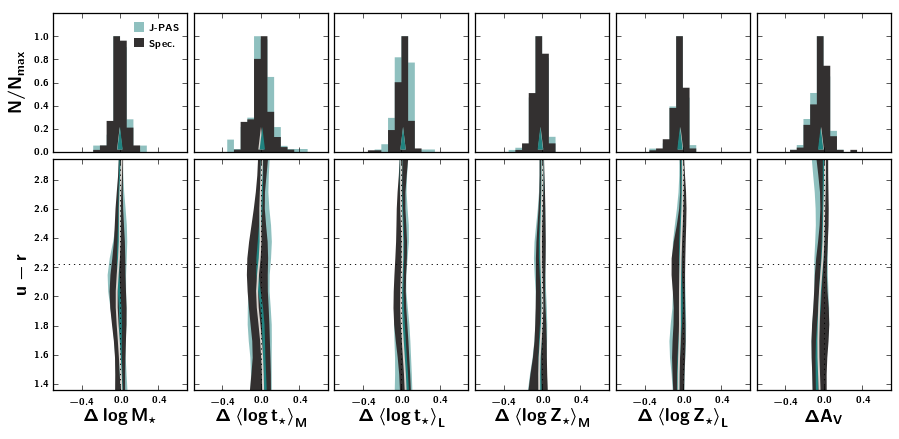

In [5]:
plot_residual_hist((spec_res_lsn, jpas_res_lsn), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)
plot_residual_hist((spec_res_tta, jpas_res_tta), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)
plot_residual_hist((spec_res_hsn, jpas_res_hsn), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)

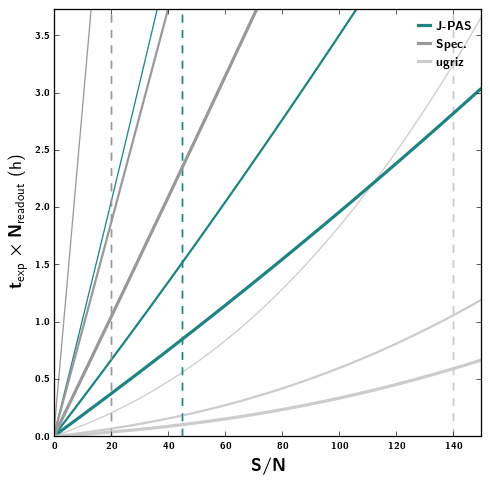

In [9]:
#select one galaxy in r=16,18,20 bins
bins = percentile(cat["r_mag"], [5,50,95])

true_snr = [snr["snr_wall"][argmin(abs(mag-cat["r_mag"]))] for mag in bins]
isort = argsort(true_snr)
true_snr = np.sort(true_snr)

spec_name = array([cat["input_file"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]
true_mag = array([cat["r_mag"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]

#get relevant data from FITS: expTime, readout noise, etc.
fdir = os.path.expandvars("$phd/inputs/real_deal/fits/")
spec_fits = [fits.open(fdir+fit) for fit in spec_name]
spec_expt = [f[0].header["EXPTIME"] for f in spec_fits]
spec_nr = [int(expt/60./15.) for expt in spec_expt]

F_spec = []
for i,f in enumerate(spec_fits):
    #read original (observed SED)
    wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
    wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
    flux = f[0].data[0]*1e-17
    wlen = wlen[flux>0]
    flux = flux[flux>0]
    #compute spectroscopic F = mean(F_lambda*h_s)
    F_spec.append(F(true_snr[i], F_sky=0.0, N_pix=N_pix_spec(), t=spec_nr[i]*spec_expt[i], readout_noise=spec_nr[i]*3.0))
    #using the expTime, reproduce the reported SNR values
    #print true_snr[i], SNR_astropy(spec_nr[i]*spec_expt[i], F_spec[i], 0.0, 0.0, spec_nr[i]*3.0, N_pix_spec())

#compute photometric F = sum(F_i*h_i)/nf ~ F_spec for the J-PAS filter set
F_pho = map(lambda x: x/0.25*0.5, F_spec)

tt = linspace(5.0, 60*4*56., 1000)
lws = [1, 1.75, 2.5]
for i in xrange(len(spec_name)):
    #compute the J-PAS SNR using the instrument values from Benitez et al. 2014
    SNR_jpas = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 4., 56*4*N_pix_imag(D=3., ps=0.227))#SNR_phot(F_pho[i], t, dlambda=140., h=0.7, nf=56., D=3., nr=4., sigma=4., ps=0.2267)
    #also plot SDSS photometry for comparison
    SNR_ugriz = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 4., 5*N_pix_imag(D=3., ps=0.396))#SNR_phot(F_pho[i], t, dlambda=1200., h=0.5, nf=5., D=3., nr=1., sigma=4., ps=0.396)
    #plot the SNR vs. t for the SDSS spectra and for the J-PAS
    SNR_sdss = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 3*4., N_pix_spec(R=1800., D=3., ps=0.396))#SNR_spec(F_spec[i], t, L=5400., h=0.3, nr=3.)

    axvline(45., ls="--", color="#218380", lw=1)
    axvline(20., ls="--", color="0.6", lw=1)
    axvline(140, ls="--", color="0.8", lw=1)

    if i==2:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i], label=r"\bf J-PAS")
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i], label=r"\bf Spec.")
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i], label=r"\bf ugriz")
    else:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i])
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i])
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i])

legend(loc=1, fontsize="x-small")
xlim(0,150)
ylim(0,tt.max()/3600)

xlabel(r"$S/N$")
ylabel(r"$t_\text{exp}\times N_\text{readout}$ (h)")

# $S/N$ proof Summary

From the SDSS observed sample, three different sources with spectral energy distribution (SED) $f_\lambda$ were studied, with fiber $r$-magnitude $19.0521$, $18.0314$, and $17.0769\,$mag and corresponding $S/N\approx10$, $16$, and $32$ (thin, medium and thick line, respectively). The average photon count, $\bar{F}$ measured by the instrument was cumputed using the SDSS spectrograph set up: $\eta=0.25$, $p_s=0.396\,$arcsec/pixel, $R=1800$, and $\sigma_r=4\,$e$^{-}$; in all cases assuming a **no sky background nor dark noise** measurement and using as input $S/N$ the one computed over all wavelengths. The number of exposures and the total exposure time ($t_\text{exp}\times N_\text{readout}$) were read from the SDSS-DR7 FITS (1d) files to ensure a realistic estimation of the photon count.

Using the same value $\bar{F}$, the corresponding $S/N$ values were computed for photometric observations using the J-PAS camera set up: $\eta=0.7$, d$\lambda\approx140\,$Angströms, $p_s=0.2267\,$arcsec/pixel, $N_\text{filters}=56$, $N_\text{readout}=4\times N_\text{filters}$, and $\sigma_\text{readout}=4\,$e$^{-}$, and the equation:
$$
S/N = \frac{\bar{F}\eta t_\text{exp}N_\text{readout}}{\sqrt{t_\text{exp}N_\text{readout}\left[\bar{F}\eta + N_\text{pixels}\left(\bar{F}_\text{sky}\eta+\sigma_\text{dark}\right)\right] + N_\text{pixels}\sigma_\text{readout}^2}},
$$
where
$$
N_\text{pixels} = \pi N_\text{filters}\left(\frac{D}{2p_s}\right)^2,
$$
for imaging and
$$
N_\text{pixels} = 2R\frac{D}{p_s},
$$
for spectroscopy. Correspondingly, $D$ is the aperture and $R=\lambda/\delta\lambda$ is the spectral resolution.
Throughout this excercise

A comparison of the total exposure time in hours as a function of the required $S/N$ is shown in the plot for the three different sources assuming the two instrumental set ups aforementioned. The upper limit in the total time represents the **minimum exposure** time planned for the J-PAS (see Benítez+2014). From this plot is clear that J-PAS will take longer exposures to reach the assumed $S/N=45$ in mock simulations, even with the brighter source ($r\sim17\,$mag) used in this example.

## Referee questions

#### Presumably $S/N=45$ for spectroscopy would yield better results than for narrow-band photometry?
Yes, the bias and the precision are both tightly related to the $S/N$. The better $S/N$ the better physical parameter estimation.

#### $S/N=20$ for the photometry might result in larger biases?
Yes, the same analysis above also apply in this case.

#### Is it really cheaper to get $S/N=45$ in $56$ bands than $S/N=20$ spectroscopy with a multiplexed spectrograph?
The plot above seems to clearly indicate it is not. Nevertheless, the most important factor to decide which type of observation is cheaper is the survey speed, i.e., the number of objects of interest observed per total exposure time. Multiplexed spectroscopy surveys are typically $\sim1000$ (the SDSS-DR7 instruments were $640$ sources per exposure), mostly due to engineering limitations. On the other hand, photometric survey speed depend mostly on the field of view (FOV). In particular the J-PAS main instrument will have a FOV$\sim3$ square degrees (similar to the SDSS imaging camera), the expected number of galaxies per exposure is $>10^4$. So in the long run, J-PAS will be cheaper than tranditional multiplexed spectroscopy.

#### Is $S/N=45$ the typical expected $S/N$ of the J-PAS survey?
Local bright galaxies will require longer than the minimum total exposure time planned for the J-PAS to reach the assumed $S/N=45$, as shown in the plot above. So the only way to get a $S/N=45$ with the J-PAS survey planning is to observe very bright local sources.

#### Is the main reason for the assumed SNRrs to relate the TTA to the later results on real galaxies, where the synthetic J-PAS and $ugriz$ photometry does indeed have high S/N?
Yes. Although in the plot above can be seen the assumed $S/N=145$ for the $ugriz$ photometry can be easily reached within a few minutes of exposure time for the brightest source in our sample.

## TTA versus $S/N$

The TTA simulations were repeated using $$